In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import folium

In [2]:
df_05 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202205-divvy-tripdata.csv')
df_06 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202206-divvy-tripdata.csv')
df_07 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202207-divvy-tripdata.csv')
df_08 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202208-divvy-tripdata.csv')
df_09 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202209-divvy-publictripdata.csv')
df_10 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202210-divvy-tripdata.csv')
df_11 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202211-divvy-tripdata.csv')
df_12 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202212-divvy-tripdata.csv')
df_01 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202301-divvy-tripdata.csv')
df_02 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202302-divvy-tripdata.csv')
df_03 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202303-divvy-tripdata.csv')
df_04 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202304-divvy-tripdata.csv')

df = pd.concat([df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_01, df_02, df_03, df_04], ignore_index=True)
df = df.dropna().reset_index(drop=True)
print("Nach Entfernen der NaN-Werte:", df.shape[0])

# find all unique stations
unique_stations_start = df.groupby('end_station_id').first().reset_index()

# convert the timestamp 
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Calculate 'ride duration'
df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Filter of trips that take between 5 and 120 minutes
df = df[(df['ride_duration'] >= 5) & (df['ride_duration'] <= 120)]
print("Nach Filterung der Fahrdauer:", df.shape[0])

# Save of the filtered df
df_start = df

Nach Entfernen der NaN-Werte: 4533999
Nach Filterung der Fahrdauer: 3622812


In [3]:

# Angenommen, df ist dein Haupt-DataFrame, der alle Trips enthält

# Berechnung der Gesamttrips je Station
total_trips_per_station = df_start.groupby('end_station_id')['ride_id'].count().reset_index(name='total_trips')

# Filtern der Stationen mit weniger als 100 Trips
stations_to_remove = total_trips_per_station[total_trips_per_station['total_trips'] < 200]['end_station_id']

# Entfernen der Stationen mit weniger als 100 Trips aus dem Haupt-DataFrame
df_filtered = df_start[~df_start['end_station_id'].isin(stations_to_remove)]

unique_stations_filtered = unique_stations_start[~unique_stations_start['end_station_id'].isin(stations_to_remove)]

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

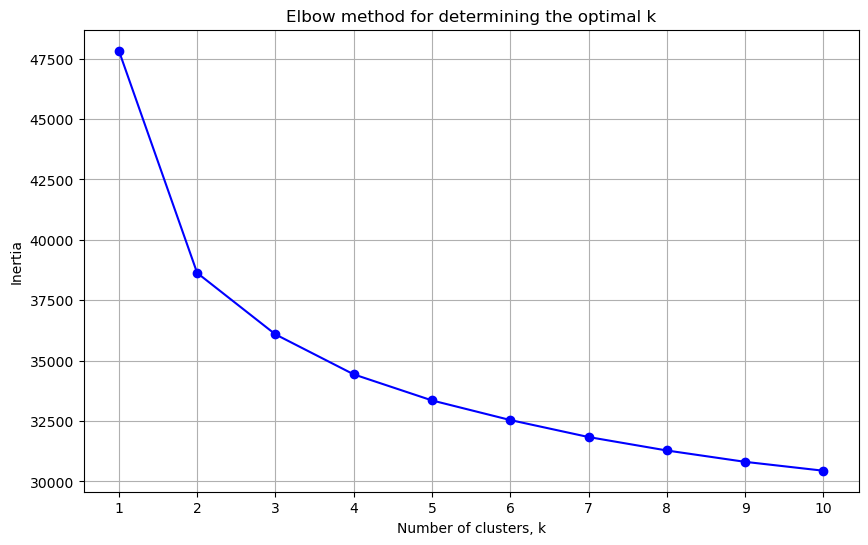

In [4]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_filtered.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# Elbow method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_rowwise)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow method for determining the optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

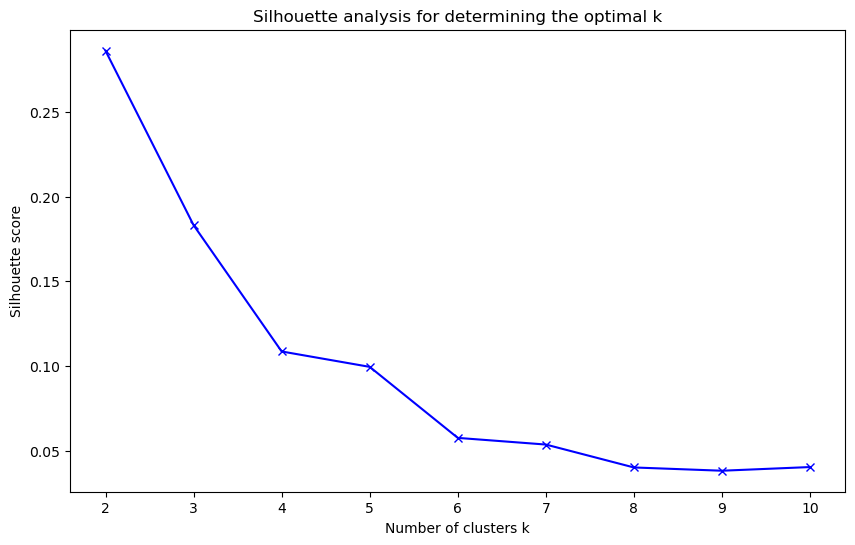

In [5]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht


df = df_filtered.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

silhouette_scores = []
K = range(2, 11)  # Silhouetten-Score kann nicht mit k=1 berechnet werden
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_rowwise)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_features_rowwise, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for determining the optimal k')
plt.show()



In [6]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_filtered.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# Now, scaled_features_rowwise is correctly formatted for kmeans
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed for your analysis
clusters = kmeans.fit_predict(scaled_features_rowwise)

# Add the cluster assignments back to the DataFrame
pivot_df['cluster'] = clusters

df = df_filtered.merge(pivot_df[['end_station_id', 'cluster']], on='end_station_id', how='left')
unique_stations = unique_stations_filtered.merge(pivot_df[['end_station_id', 'cluster']], on='end_station_id', how='left')

# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_stations = unique_stations['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_stations)

# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_df = df['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_df)

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.0    346
2.0    179
1.0     89
Name: cluster, dtype: int64
0    2193601
2     755045
1     644256
Name: cluster, dtype: int64


In [7]:

unique_stations = unique_stations.dropna(subset=['cluster'])
unique_stations['cluster'] = unique_stations['cluster'].astype(int)
# Erstellung einer Karte zentriert um die durchschnittlichen Koordinaten
map_clusters = folium.Map(location=[unique_stations['end_lat'].mean(), unique_stations['end_lng'].mean()], zoom_start=13)

# Farben für die Cluster
colors = ['blue', 'orange', 'green']

# Hinzufügen der Stationen zur Karte mit farbiger Markierung je nach Cluster
for lat, lon, cluster in zip(unique_stations['end_lat'], unique_stations['end_lng'], unique_stations['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[cluster % len(colors)],  # Um sicherzustellen, dass die Farbenindexierung innerhalb der Grenzen bleibt
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.7).add_to(map_clusters)

# Anzeige der Karte direkt im Notebook
map_clusters

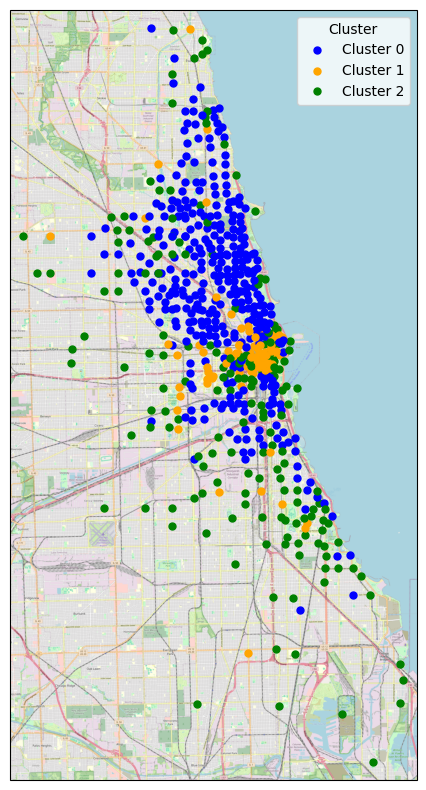

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# Beispiel-Daten (Annahme, dass unique_stations bereits definiert ist)
# unique_stations sollte DataFrame mit Spalten 'start_lat', 'start_lng' und 'cluster' sein

unique_stations = unique_stations.dropna(subset=['cluster'])
unique_stations['cluster'] = unique_stations['cluster'].astype(int)

# Farben für die Cluster
colors = ['blue', 'orange', 'green',]

# Erstellen der Karte
def plot_cluster_map(data, title=''):
    # OpenStreetMap als Kartenhintergrund
    osm = OSM()
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': osm.crs})  # Breiteres Layout

    # Koordinaten für das gewünschte Gebiet (z.B. Durchschnittskoordinaten)
    extent = [
        data['end_lng'].min() - 0.01, data['end_lng'].max() + 0.01,
        data['end_lat'].min() - 0.01, data['end_lat'].max() + 0.01
    ]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Füge den Kartenhintergrund hinzu
    ax.add_image(osm, 13)  # Die Zahl bestimmt die Zoomstufe der Karte

    # Plotte jede Station
    for idx, row in data.iterrows():
        color = colors[row['cluster'] % len(colors)]
        ax.plot(row['end_lng'], row['end_lat'], 'o', color=color, markersize=5, transform=ccrs.Geodetic())

    # Erstelle eine Legende
    legend_elements = [
        plt.Line2D([], [], marker='o', color=colors[i], markersize=5, linestyle='', label=f'Cluster {i}')
        for i in range(len(colors))
    ]
    ax.legend(handles=legend_elements, loc='upper right', title="Cluster")

    plt.title(title)
    plt.show()

# Beispiel-Daten plotten
plot_cluster_map(unique_stations)


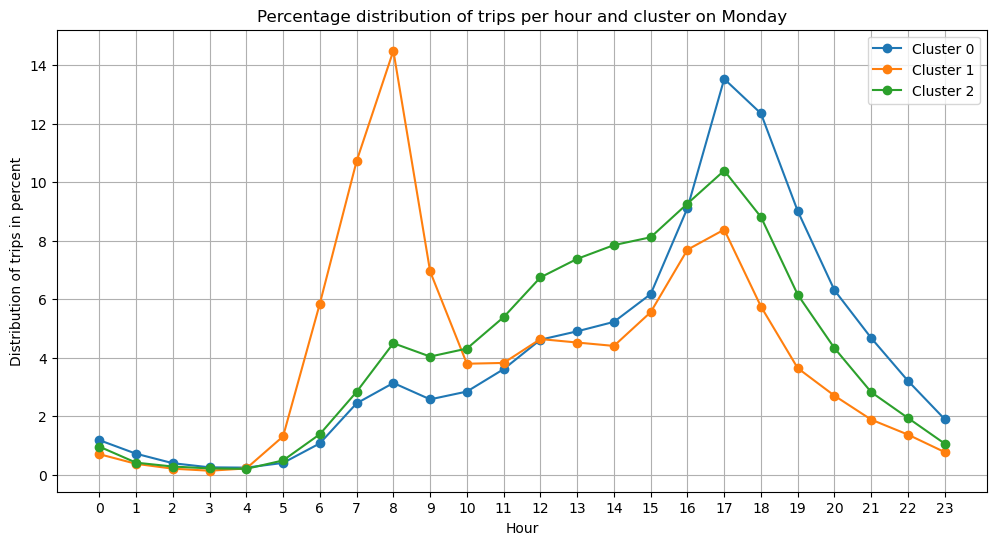

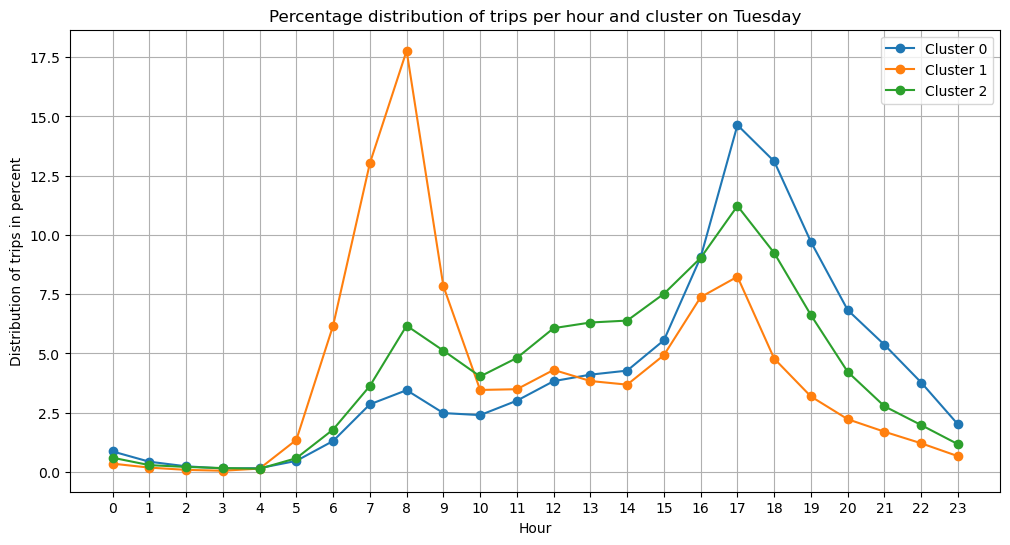

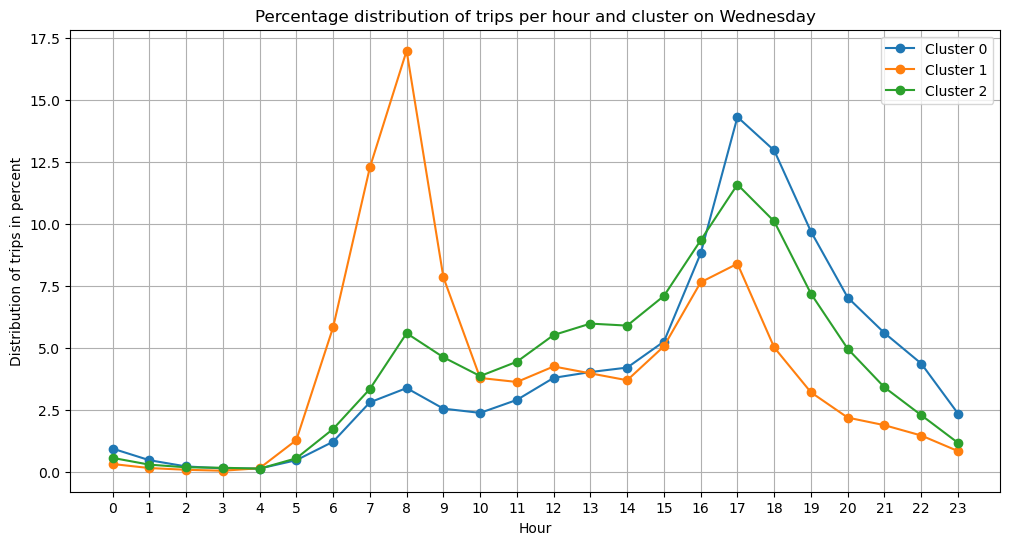

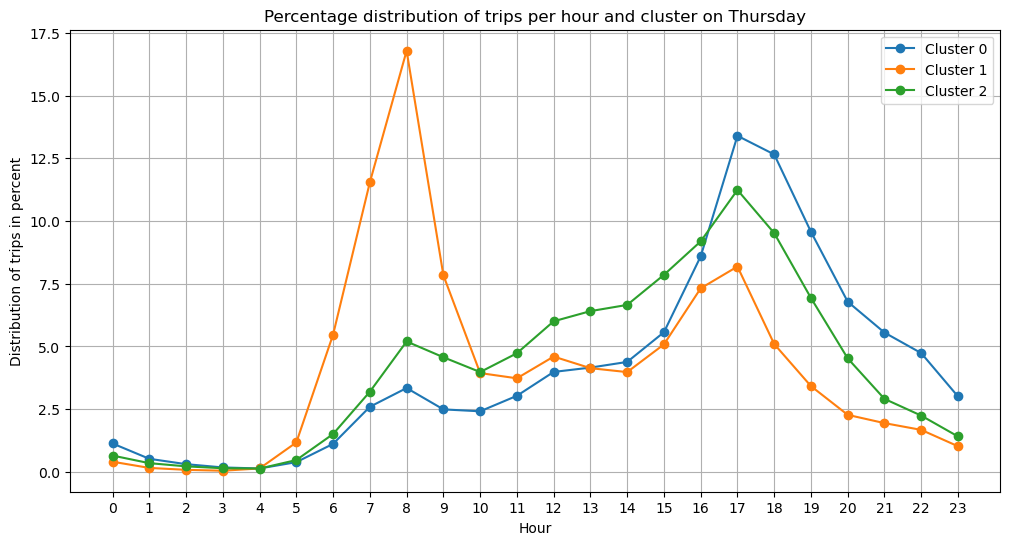

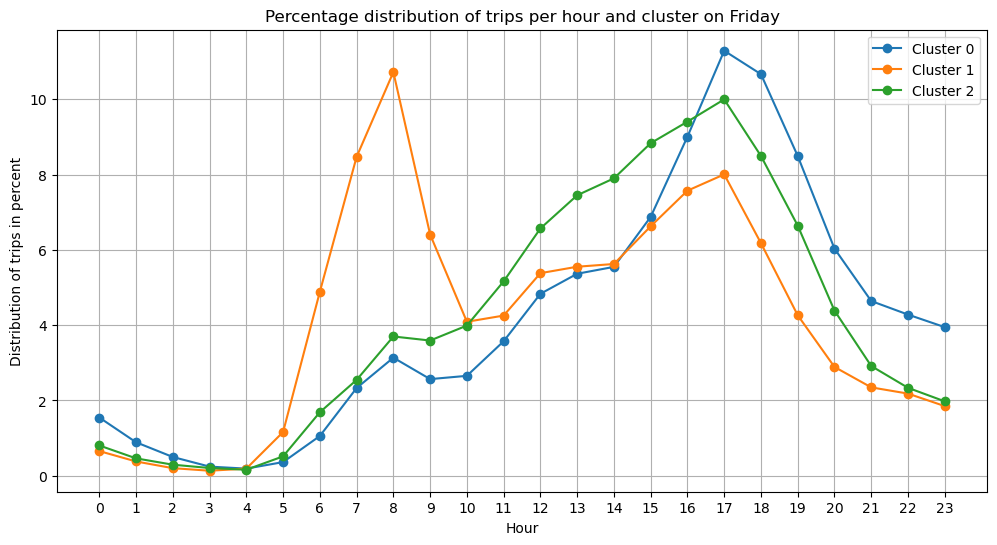

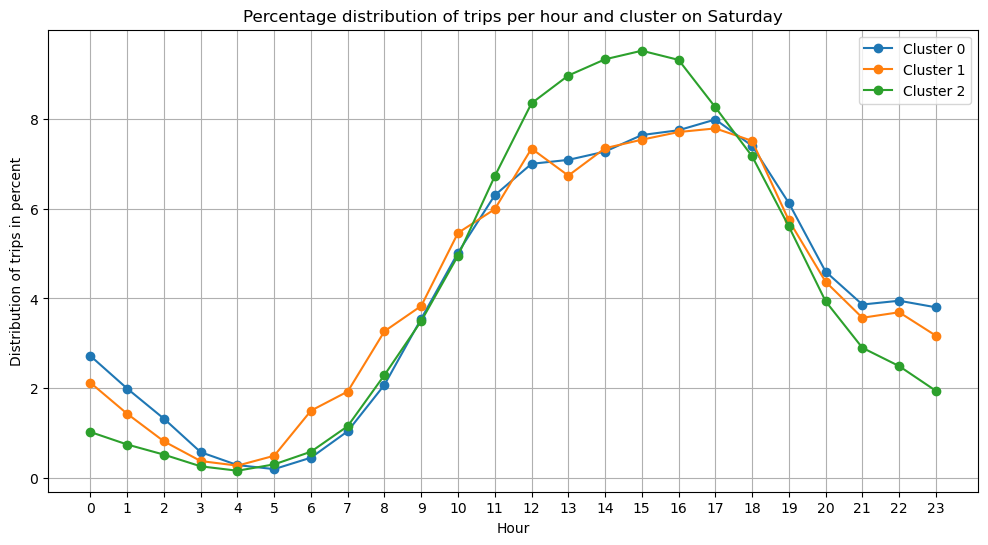

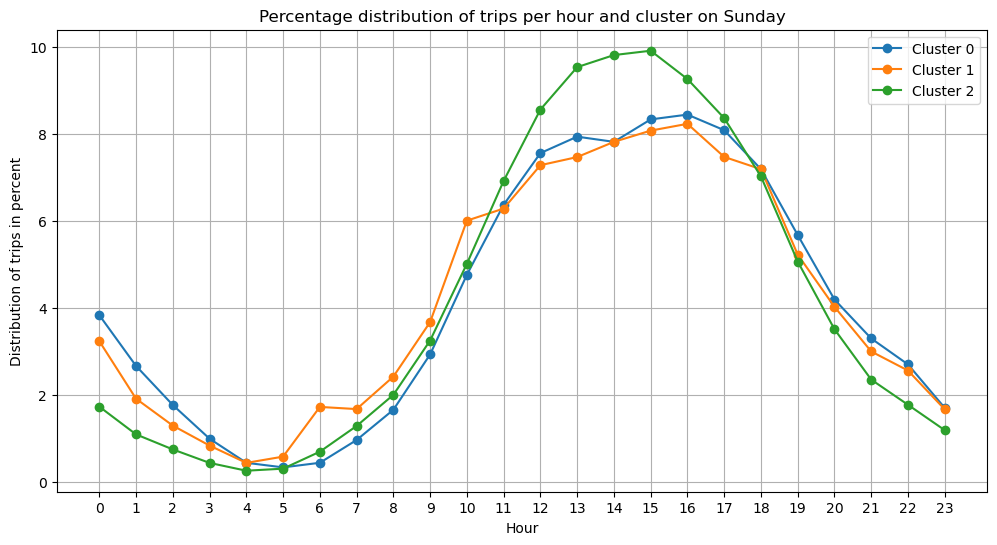

In [12]:
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

# 1. Gesamtzahl der Fahrten pro Cluster und Wochentag
total_rides_cluster_weekday = df.groupby(['cluster', 'weekday']).ride_id.count().reset_index(name='total_cluster_weekday_rides')

# 2. Stündliche Fahrten pro Cluster und Wochentag
hourly_rides_cluster_weekday = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='hourly_cluster_rides')

# 3. Zusammenführen der Gesamt- und stündlichen Fahrten
merged_rides = pd.merge(hourly_rides_cluster_weekday, total_rides_cluster_weekday, on=['cluster', 'weekday'])

# 4. Prozentualen Anteil berechnen
merged_rides['percentage'] = (merged_rides['hourly_cluster_rides'] / merged_rides['total_cluster_weekday_rides']) * 100

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = merged_rides.pivot_table(index=['hour', 'weekday'], columns='cluster', values='percentage', fill_value=0)

# Definiere eine Liste mit Wochentagsnamen
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:  # Überprüfung, ob der Cluster vorhanden ist
            data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
            plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')

        
    plt.title(f'Percentage distribution of trips per hour and cluster on {weekdays[weekday]}')
    plt.xlabel('Hour')
    plt.ylabel('Distribution of trips in percent')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()

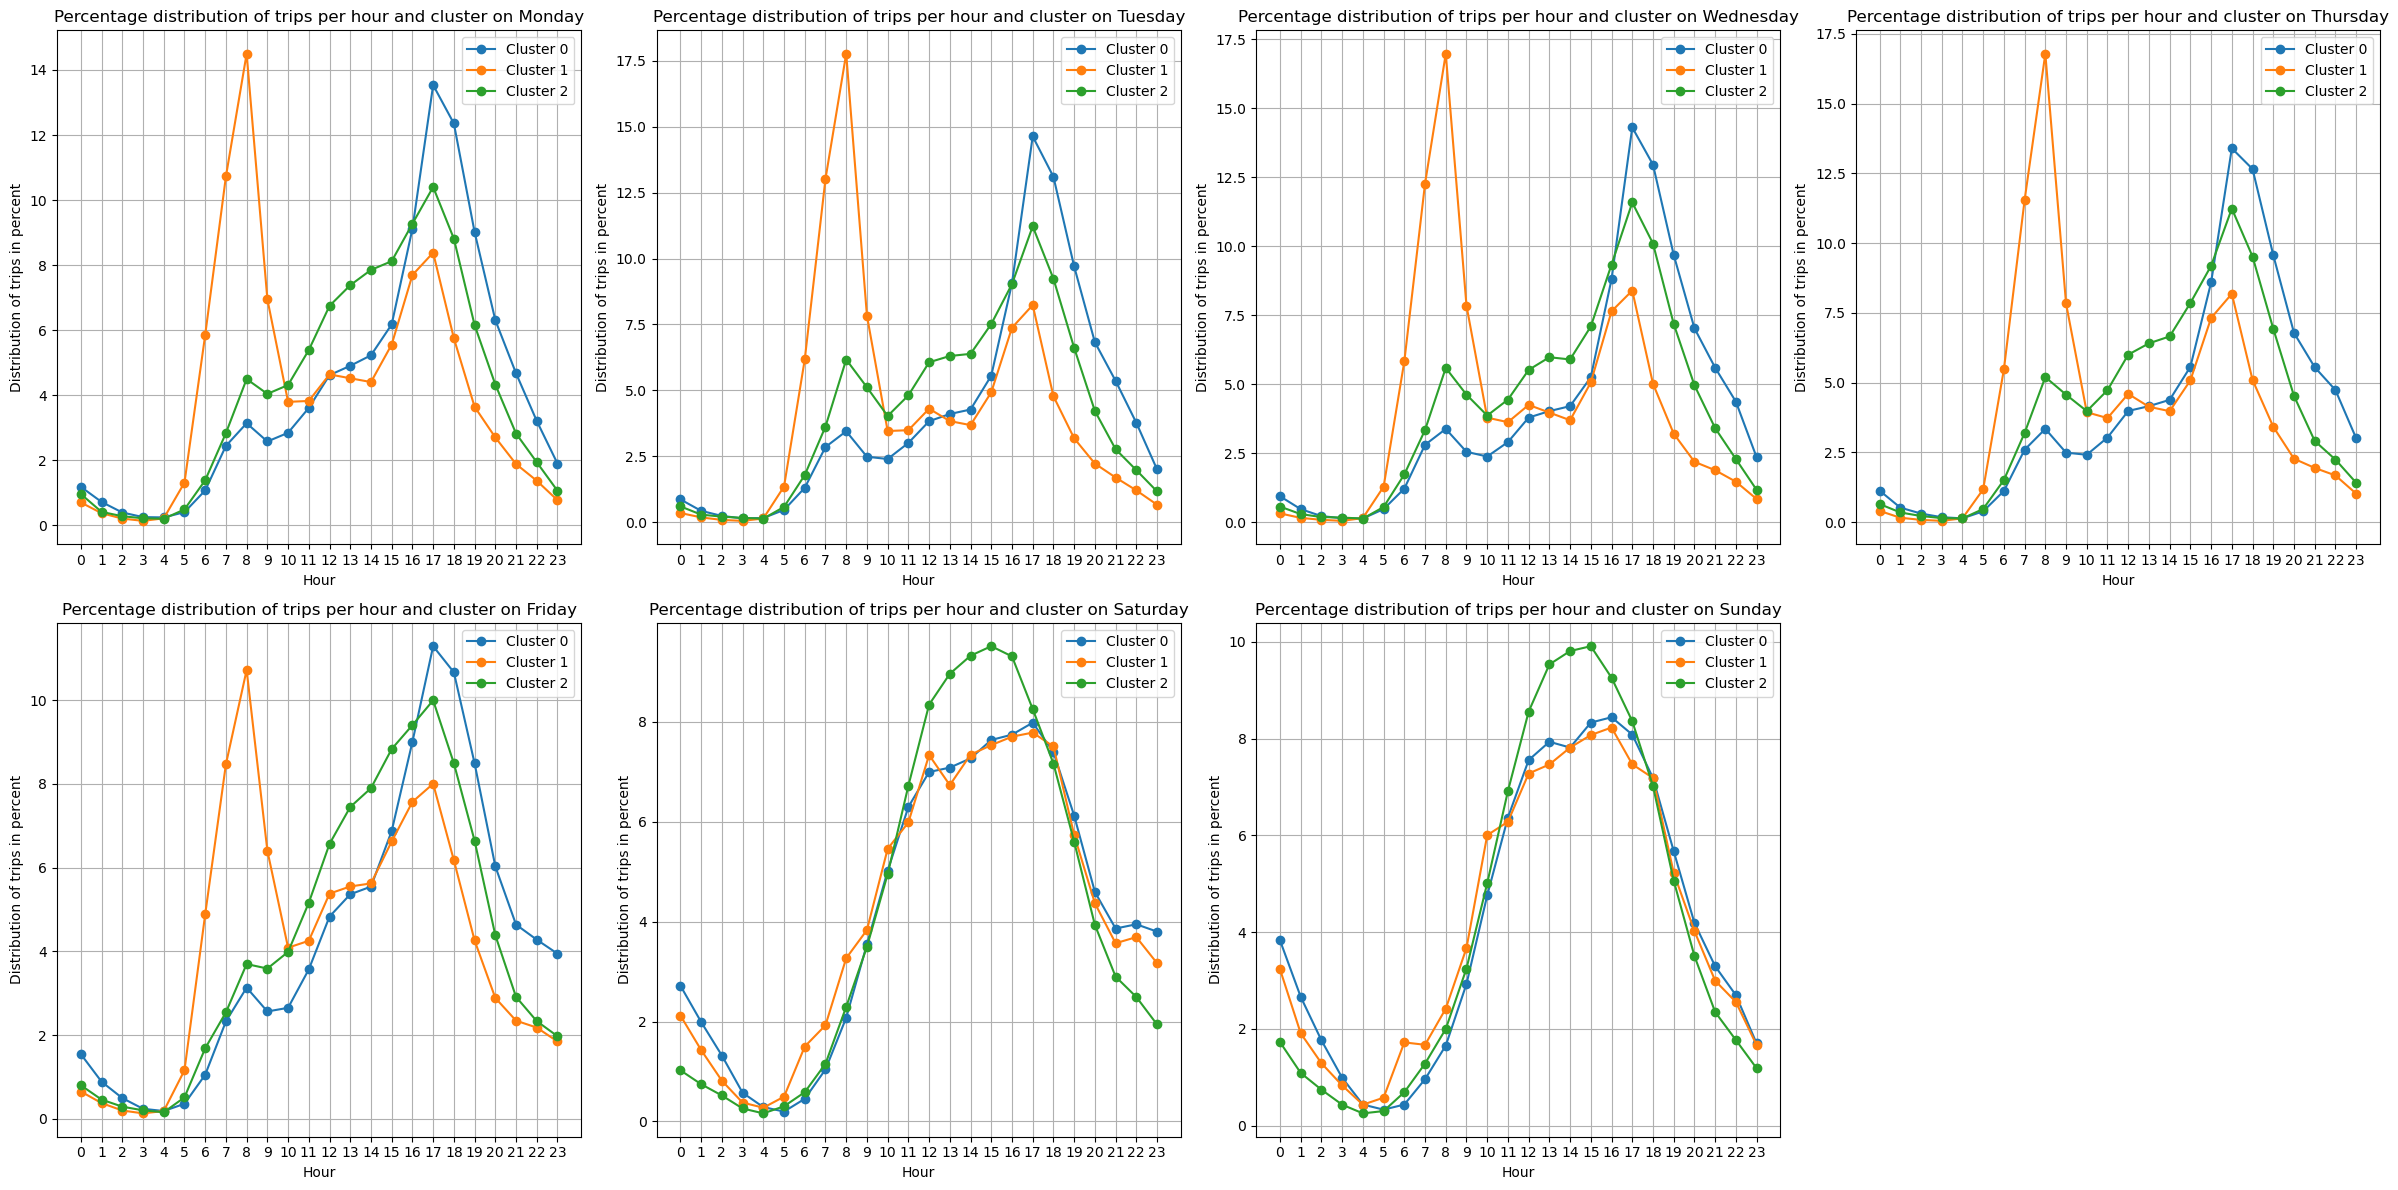

In [13]:


# Definiere eine Liste mit Wochentagsnamen
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Erstelle eine Figure und mehrere Axes für Subplots
# 2 Reihen, 4 Subplots in der ersten Reihe und 3 in der zweiten
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))  # Passt die Größe und Anzahl der Subplots an

# Plotten jedes Wochentags in einem eigenen Subplot
for i, ax in enumerate(axes.flatten()[:7]):  # Verwende flatten, um mit einer eindimensionalen Liste zu arbeiten
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:
            data_to_plot = pivot_data.xs(i, level='weekday')[cluster]
            ax.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')

    # Hier wird der korrekte Wochentag aus der Liste zugeordnet
    ax.set_title(f'Percentage distribution of trips per hour and cluster on {weekdays[i]}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Distribution of trips in percent')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind

# Entferne den achten Subplot, der nicht benötigt wird
axes[1, 3].axis('off')  # Schaltet den achten Subplot aus

plt.tight_layout()  # Verbessert die Anordnung, um Überlappungen zu vermeiden
plt.show()


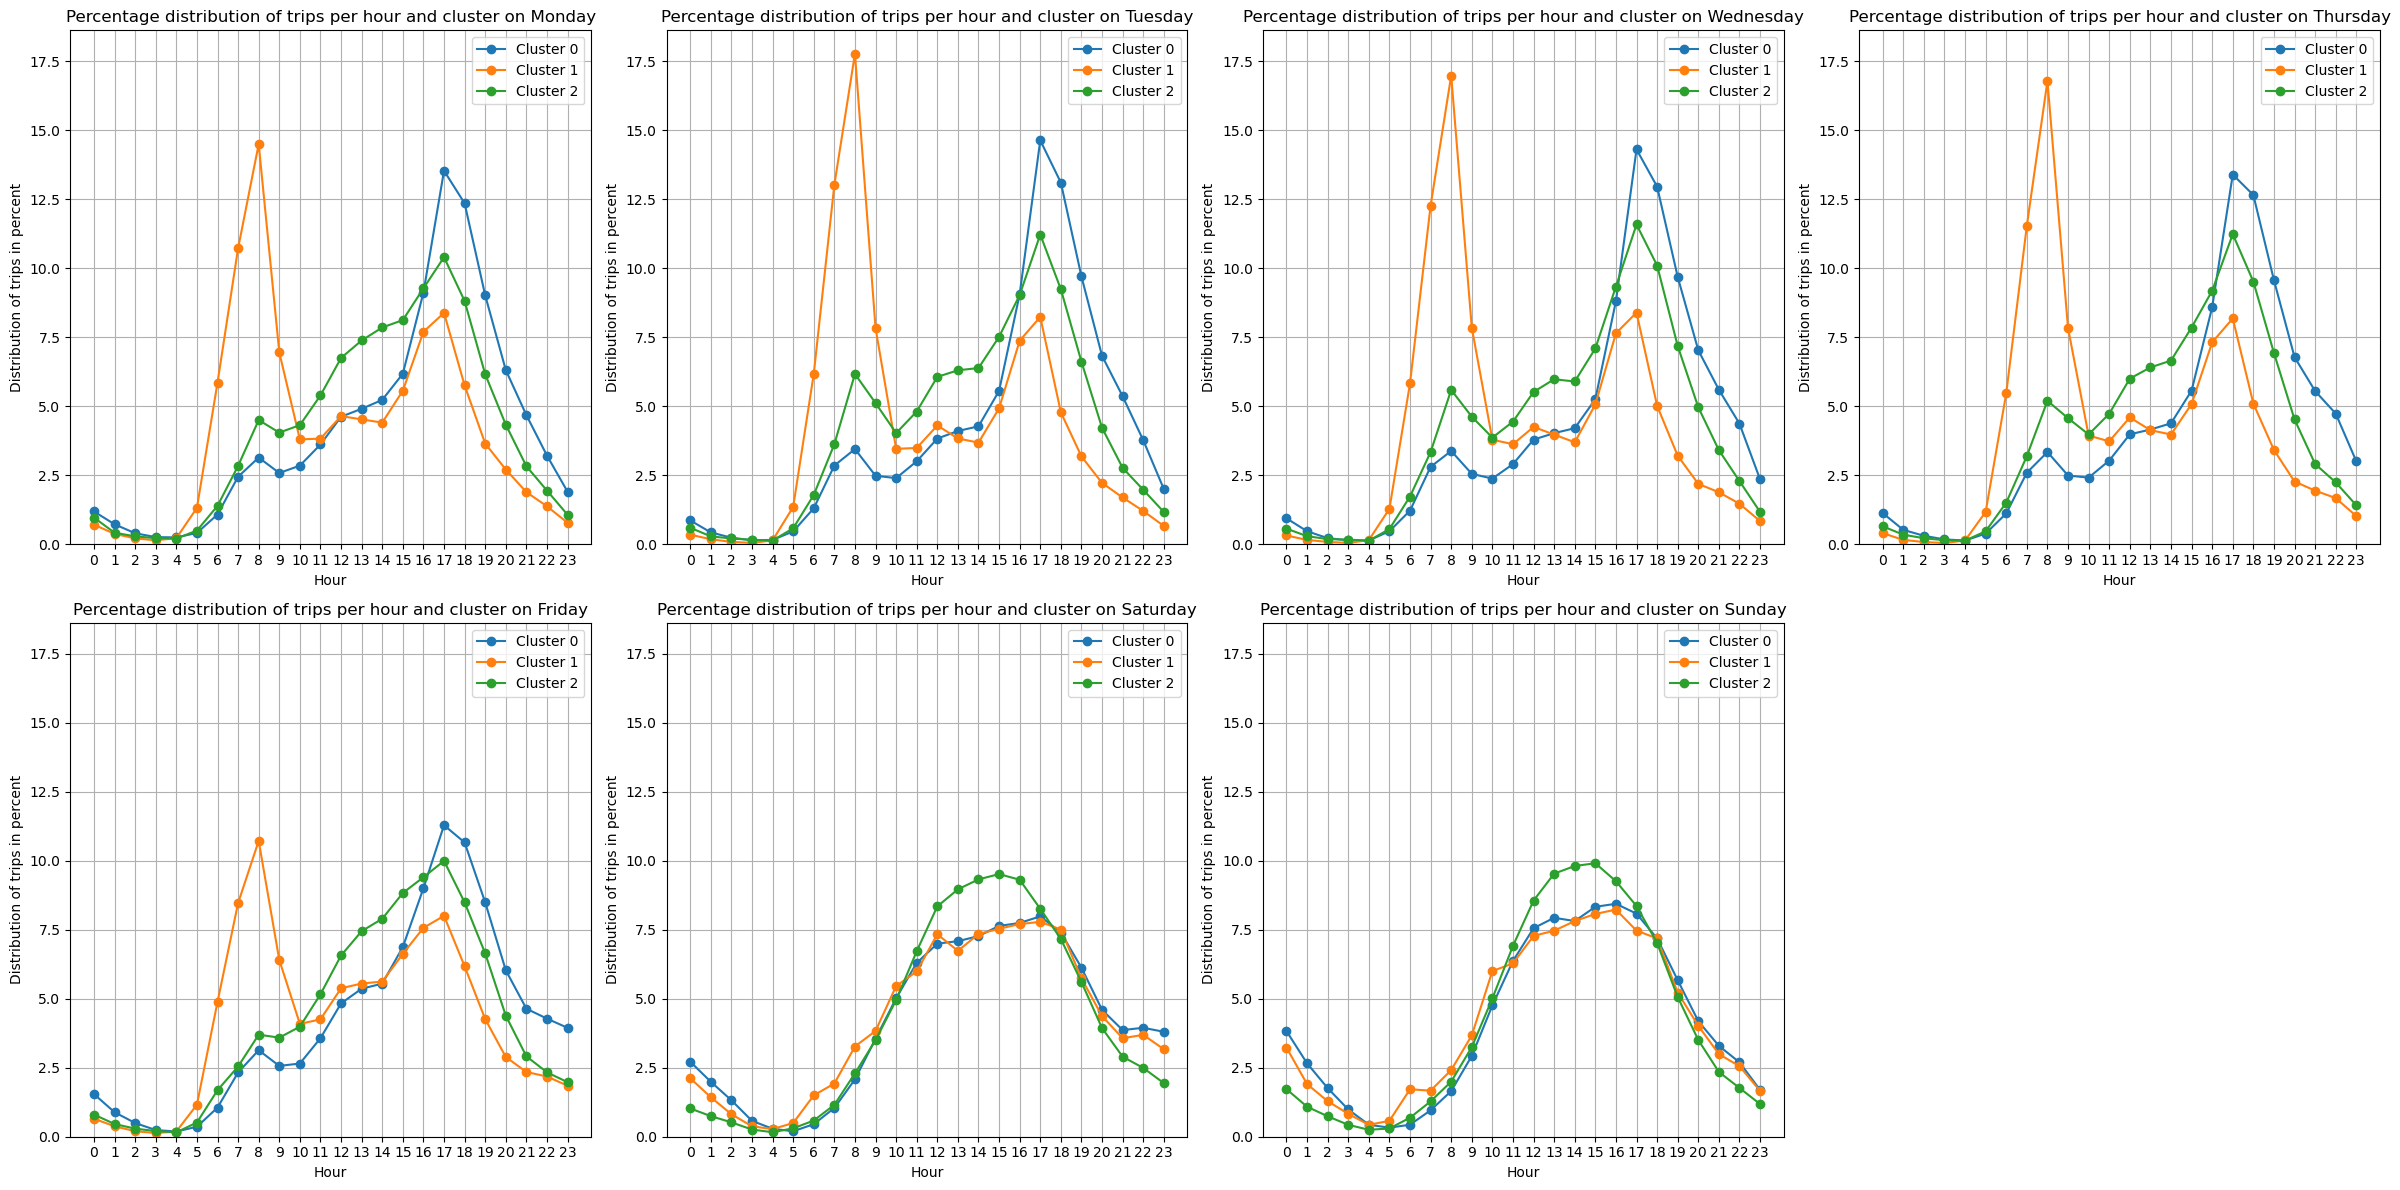

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Definiere eine Liste mit Wochentagsnamen
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Erstelle eine Figure und mehrere Axes für Subplots
# 2 Reihen, 4 Subplots in der ersten Reihe und 3 in der zweiten
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))  # Passt die Größe und Anzahl der Subplots an

# Finde den maximalen Wert, um die y-Achse zu skalieren
max_y = 0
for i in range(7):
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:
            data_to_plot = pivot_data.xs(i, level='weekday')[cluster]
            max_y = max(max_y, data_to_plot.max()) +0.05

# Plotten jedes Wochentags in einem eigenen Subplot
for i, ax in enumerate(axes.flatten()[:7]):  # Verwende flatten, um mit einer eindimensionalen Liste zu arbeiten
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:
            data_to_plot = pivot_data.xs(i, level='weekday')[cluster]
            ax.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')

    # Hier wird der korrekte Wochentag aus der Liste zugeordnet
    ax.set_title(f'Percentage distribution of trips per hour and cluster on {weekdays[i]}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Distribution of trips in percent')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    ax.set_ylim(0, max_y)  # Setze die y-Achse gleich

# Entferne den achten Subplot, der nicht benötigt wird
axes[1, 3].axis('off')  # Schaltet den achten Subplot aus

plt.tight_layout()  # Verbessert die Anordnung, um Überlappungen zu vermeiden
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

# Daten konvertieren und gruppieren (dein Code)
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

total_rides_cluster_weekday = df.groupby(['cluster', 'weekday']).ride_id.count().reset_index(name='total_cluster_weekday_rides')
hourly_rides_cluster_weekday = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='hourly_cluster_rides')
merged_rides = pd.merge(hourly_rides_cluster_weekday, total_rides_cluster_weekday, on=['cluster', 'weekday'])
merged_rides['percentage'] = (merged_rides['hourly_cluster_rides'] / merged_rides['total_cluster_weekday_rides']) * 100
pivot_data = merged_rides.pivot_table(index=['hour', 'weekday'], columns='cluster', values='percentage', fill_value=0)

# Erstellen einer PDF-Datei mit einem Plot für jeden Wochentag
pdf_path = 'weekly_cluster_rides_distribution.pdf'
with PdfPages(pdf_path) as pdf:
    for weekday in range(7):  # Für jeden Wochentag
        fig, ax = plt.subplots(figsize=(12, 6))
        for cluster in sorted(df['cluster'].unique()):
            if cluster in pivot_data.columns:  # Überprüfung, ob der Cluster vorhanden ist
                data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
                ax.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')
        
        ax.set_title(f'Prozentuale Verteilung der Fahrten pro Stunde und Cluster am Wochentag {weekday}')
        ax.set_xlabel('Stunde')
        ax.set_ylabel('Prozentualer Anteil der Fahrten')
        ax.legend()
        ax.grid(True)
        ax.set_xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind

        pdf.savefig(fig)  # Speichert die aktuelle Figur im PDF
        plt.close(fig)  # Schließe die Figur nach dem Speichern


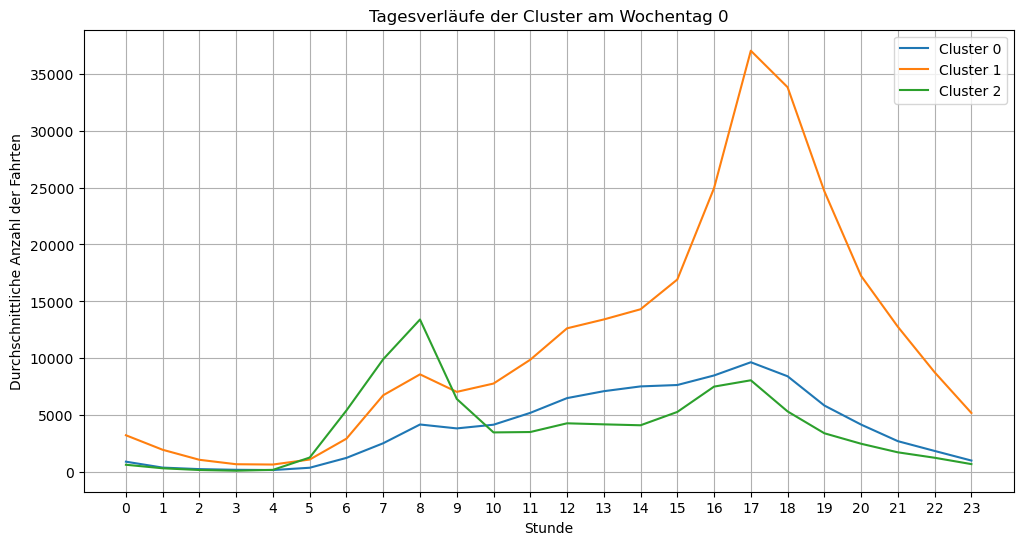

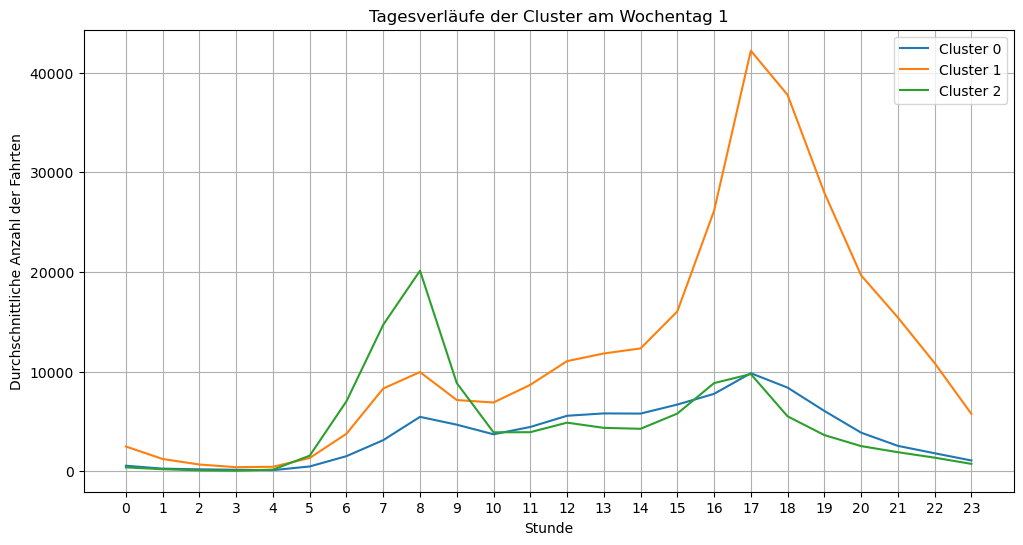

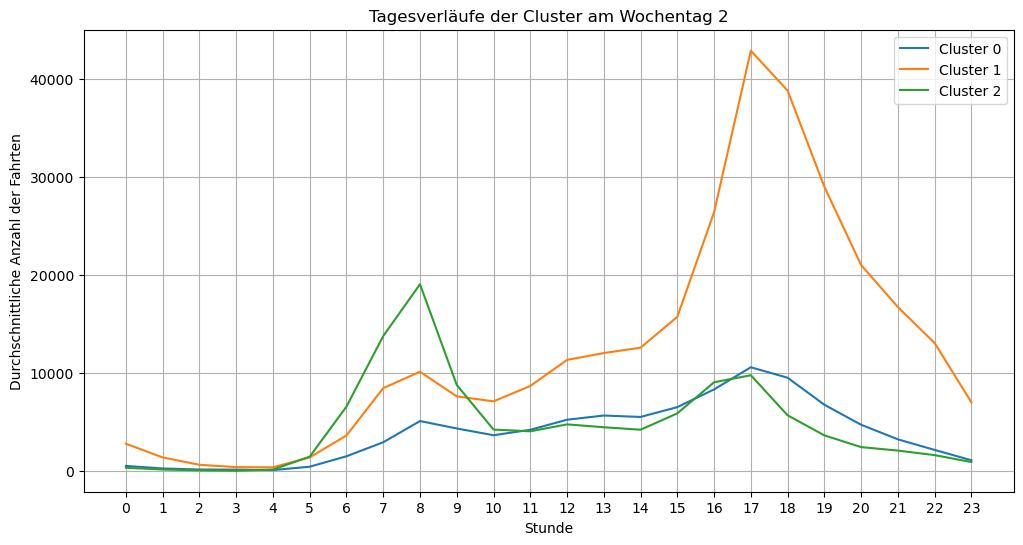

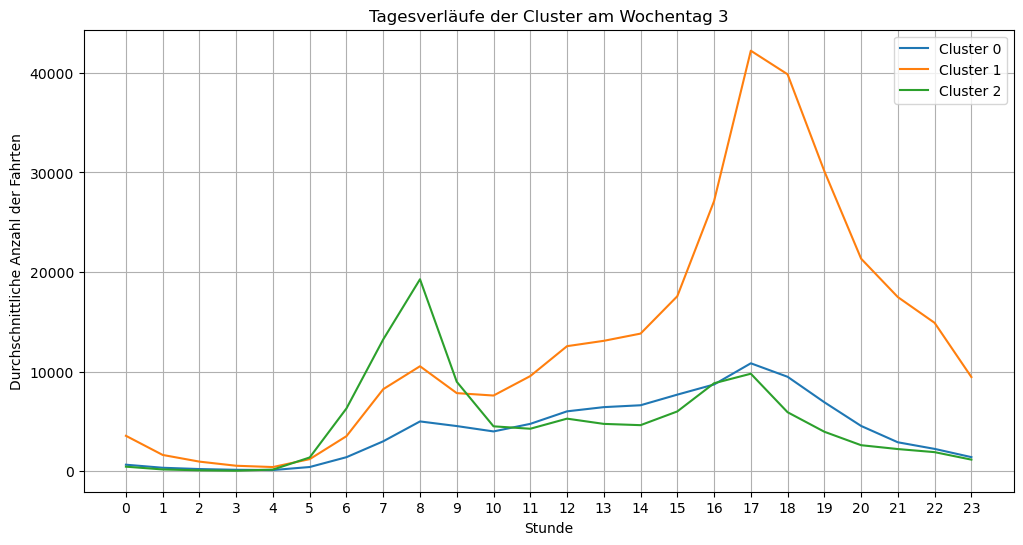

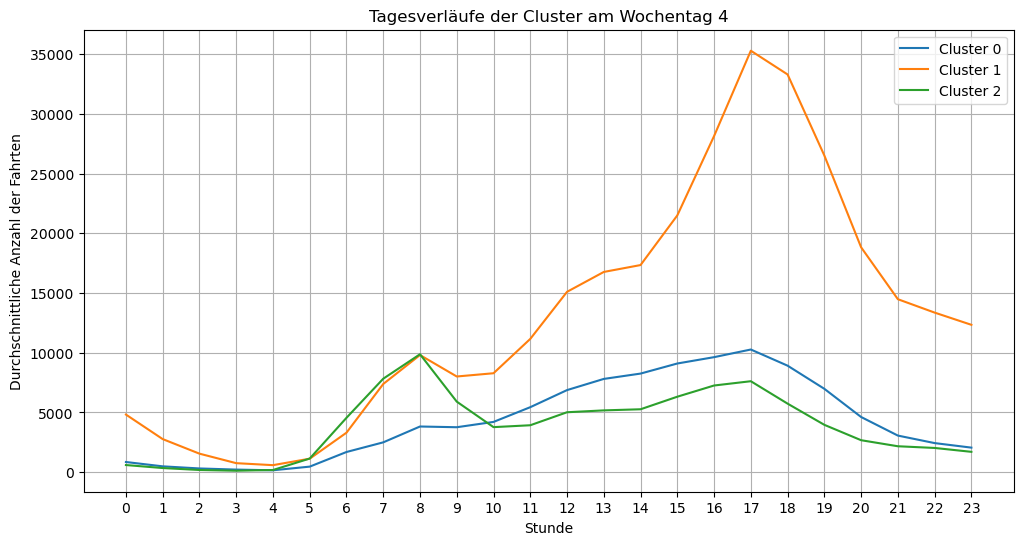

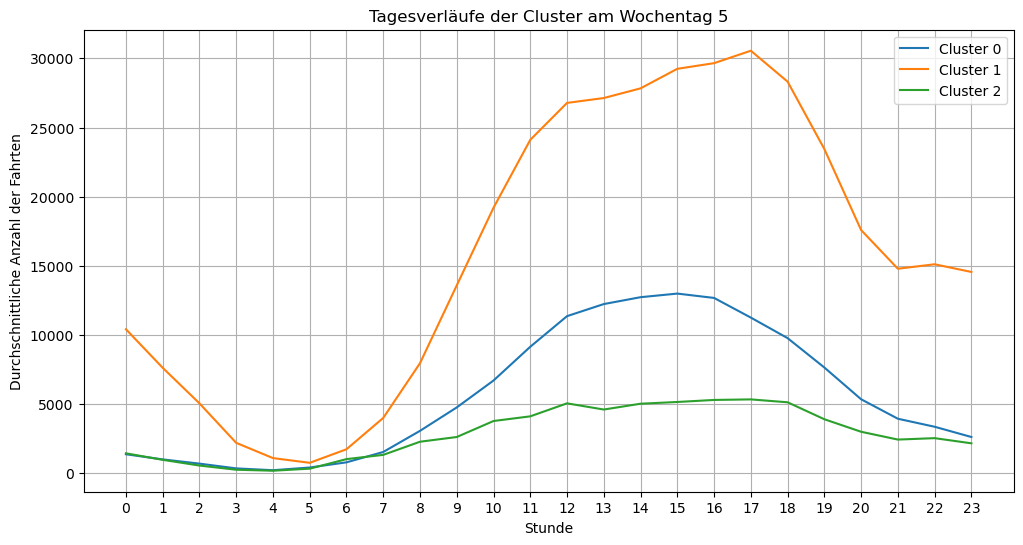

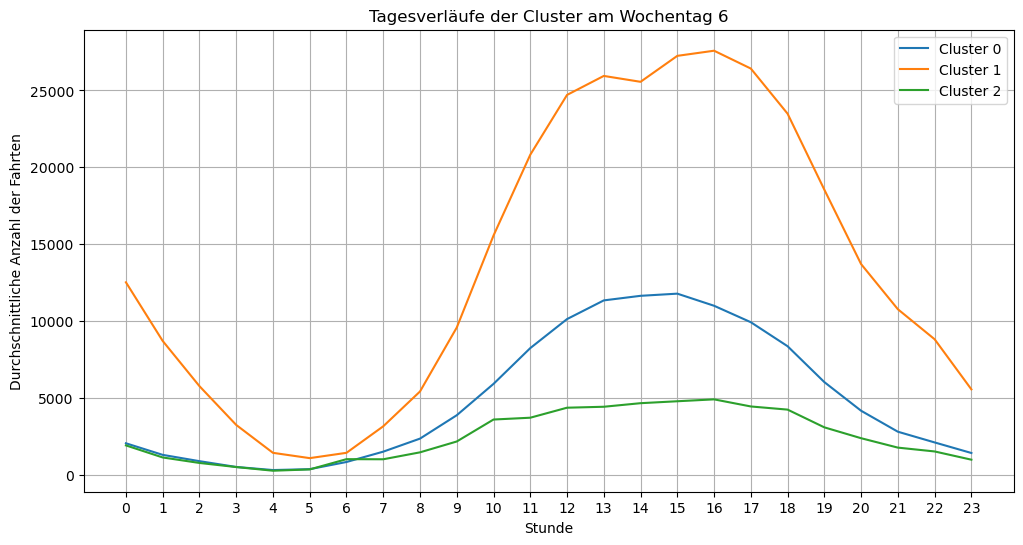

In [15]:
# Umwandlung der 'started_at' in datetime und Erstellung der 'hour' und 'weekday' Spalten, falls noch nicht vorhanden
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

# Aggregieren der Daten: Anzahl der Fahrten pro Stunde und Wochentag für jeden Cluster
agg_data = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='ride_count')

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = agg_data.pivot_table(index=['hour', 'weekday'], columns='cluster', values='ride_count', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
        plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}')
        
    plt.title(f'Tagesverläufe der Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Durchschnittliche Anzahl der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()

In [16]:
# Schritt 1: Aggregation der Fahrten pro Stunde und Wochentag für jede Station
station_hour_weekday_counts = df.groupby(['end_station_id', 'weekday', 'hour'])['ride_id'].count().reset_index(name='ride_counts')

# Schritt 2: Umwandlung in ein Pivot-Table, um Feature-Vektoren für jede Station zu erstellen
pivot_df = station_hour_weekday_counts.pivot_table(index='end_station_id', columns=['weekday', 'hour'], values='ride_counts', fill_value=0)

# Angenommen, du hast bereits ein DataFrame 'clusters' mit den Spalten 'start_station_id' und 'cluster', das die Cluster-Zuweisung für jede Station angibt
pivot_df = pivot_df.merge(unique_stations[['end_station_id', 'cluster']], on='end_station_id')

# Schritt 3: Berechnung des durchschnittlichen Feature-Vektors für jeden Cluster
cluster_feature_vectors = pivot_df.groupby('cluster').mean()

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2158/3842673609.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  pivot_df = pivot_df.merge(unique_stations[['end_station_id', 'cluster']], on='end_station_id')
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2158/3842673609.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_feature_vectors = pivot_df.groupby('cluster').mean()


In [17]:


# Angenommen, 'cluster_vectors' ist ein Array von Feature-Vektoren für die Cluster
# Beispiel: cluster_vectors = [vector1, vector2, vector3, ...]

# Berechnung der Cosine-Similarity-Matrix
similarity_matrix = cosine_similarity(cluster_feature_vectors)

# Anzeigen der Cosine-Similarity-Matrix
print(similarity_matrix)

[[1.         0.95579583 0.7781498 ]
 [0.95579583 1.         0.73430017]
 [0.7781498  0.73430017 1.        ]]
